# Проверка гипотез в бизнесе
Анализ сервиса проката самокатов GoFast. Три датасета с данными о пользователях сервиса, их поездках за один год, а также стоимости услуг в подписках. 

Задача — проанализировать демографию пользователей и особенности использования самокатов, а также определить возможную выгоду от распространения платной подписки на самокаты.

# Описание данных

Таблица с пользователями `users_go.csv`

- `user_id` — уникальный идентификатор пользователя.

- `name` — имя пользователя.

- `age` — возраст.

- `city` — город.

- `subscription_type` — тип подписки: `free`, `ultra`.

Таблица с поездками `rides_go.csv`

- `user_id` — уникальный идентификатор пользователя.

- `distance` — расстояние в метрах, которое пользователь проехал в текущей сессии.

- `duration` — продолжительность сессии в минутах, то есть время с того момента, как пользователь нажал кнопку «Начать поездку», до того, как он нажал кнопку «Завершить поездку».

- `date` — дата совершения поездки.

Таблица с подписками `subscriptions_go.csv`

- `subscription_type` — тип подписки.

- `minute_price` — стоимость одной минуты поездки по этой подписке.

- `start_ride_price` — стоимость начала поездки.

- `subscription_fee` — стоимость ежемесячного платежа.

---
## Задание 1. Загрузка данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### 1.2 Чтение данных

- https://code.s3.yandex.net/datasets/users_go.csv
- https://code.s3.yandex.net/datasets/rides_go.csv
- https://code.s3.yandex.net/datasets/subscriptions_go.csv

In [3]:
df_users_go = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
df_rides_go = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
df_subscriptions_go = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [4]:
display(df_users_go.head())
display(df_rides_go.head())
display(df_subscriptions_go.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [5]:
rows_users = len(df_users_go)
rows_rides = len(df_rides_go)
rows_subscriptions = len(df_subscriptions_go)

print(rows_users, rows_rides, rows_subscriptions)

1565 18068 2


---
## 2. Знакомство с данными и их предварительная подготовка

In [6]:
df_rides_go.dtypes

user_id       int64
distance    float64
duration    float64
date         object
dtype: object

In [7]:
df_rides_go['date'] = pd.to_datetime(df_rides_go['date'])
df_rides_go.dtypes

user_id              int64
distance           float64
duration           float64
date        datetime64[ns]
dtype: object

In [8]:
df_rides_go['month'] = df_rides_go['date'].dt.month

In [9]:
df_rides_go.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


### Поиск дубликатов

In [10]:
missing_values = df_users_go.isnull().sum().sum()  # Общее количество пропусков
duplicates = df_users_go.duplicated().sum()  # Количество полных дубликатов

print(missing_values, duplicates)

0 31


### Заполнение пропусков и удаление дублей

In [11]:
df_users_go = df_users_go.drop_duplicates()
df_rides_go = df_rides_go.fillna(0)
df_subscriptions_go = df_subscriptions_go.fillna(0)

print(df_users_go.duplicated().sum())  
print(df_rides_go.isnull().sum().sum()) 
print(df_subscriptions_go.isnull().sum().sum())

0
0
0


### Округление длительности поездки

In [12]:
df_rides_go['duration'] = df_rides_go['duration'].round().astype(int)

---
## Задание 3. Исследовательский анализ данных (EDA)

Кол-во пользователей по городам

In [13]:
users_by_city_count = df_users_go['city'].value_counts()
print(users_by_city_count)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64


Количество пользователей подписки

In [14]:
subscription_type_count = df_users_go['subscription_type'].value_counts()
print(subscription_type_count)

subscription_type
free     835
ultra    699
Name: count, dtype: int64


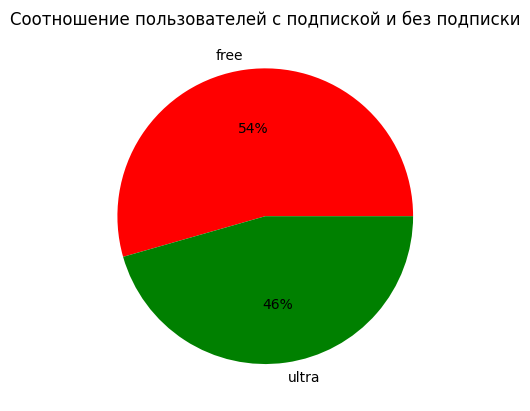

In [15]:
subscription_type_count.plot(
    kind= 'pie',
    title='Соотношение пользователей с подпиской и без подписки',
    autopct= '%.0f%%',
    ylabel= '',
    colors=['red', 'green']
)

plt.show()

### Гистограмма возрастов

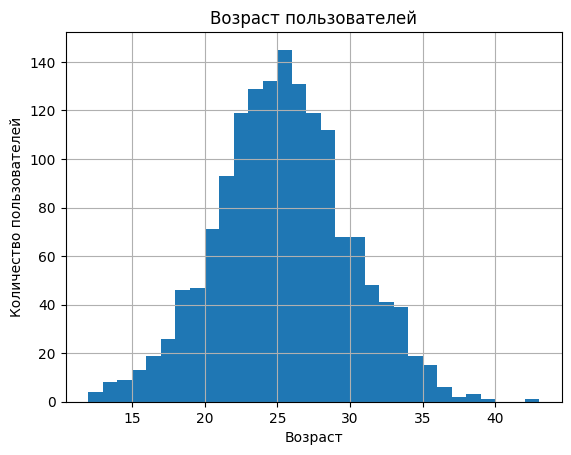

In [16]:
n_bins = df_users_go['age'].max() - df_users_go['age'].min()

df_users_go['age'].hist(bins=n_bins)

plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')

plt.show()

### Несовершеннолетние пользователи

In [17]:
# Количество несовершеннолетних пользователей
users_under_18 = (df_users_go['age'] < 18).sum()

# Общее количество пользователей
total_users = df_users_go.shape[0]

users_under_18_ratio = int(round(100 * (users_under_18 / total_users)))
print(f'Доля несовершеннолетних пользователей самокатов составляет {users_under_18_ratio}%.')

Доля несовершеннолетних пользователей самокатов составляет 5%.


### Характеристики длительности поездки

In [18]:
duration_mean = int(round(df_rides_go['duration'].mean()))  # Округляем и приводим к int
duration_std = int(df_rides_go['duration'].std())  # Приводим к int

duration_pct25 = int(df_rides_go['duration'].quantile(0.25))
duration_pct75 = int(df_rides_go['duration'].quantile(0.75))

print(f'Средняя длительность поездки {duration_mean} минут со стандартным отклонением {duration_std}. Основная часть поездок занимает от {duration_pct25} до {duration_pct75} минут.')

Средняя длительность поездки 18 минут со стандартным отклонением 6. Основная часть поездок занимает от 14 до 22 минут.


---
## Объединение данных

### Гистограмма длительности поездок для обоих групп

In [19]:
df = df_users_go.merge(df_rides_go, on='user_id', how='left')
df = df[['user_id', 'distance', 'duration', 'date', 'month', 'name', 'age', 'city', 'subscription_type']]

In [20]:
df = df.merge(df_subscriptions_go, on='subscription_type', how='left')
# Выводим первые строки датафрейма
display(df.head())

# Выводим количество строк и столбцов в объединённом датафрейме
n_rows, n_cols = df.shape
print(f'В полученном датафрейме {n_rows} строк и {n_cols} столбцов.')

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


В полученном датафрейме 18068 строк и 12 столбцов.


In [21]:
df_ultra = df[df['subscription_type'] == 'ultra']
df_free = df[df['subscription_type'] == 'free']


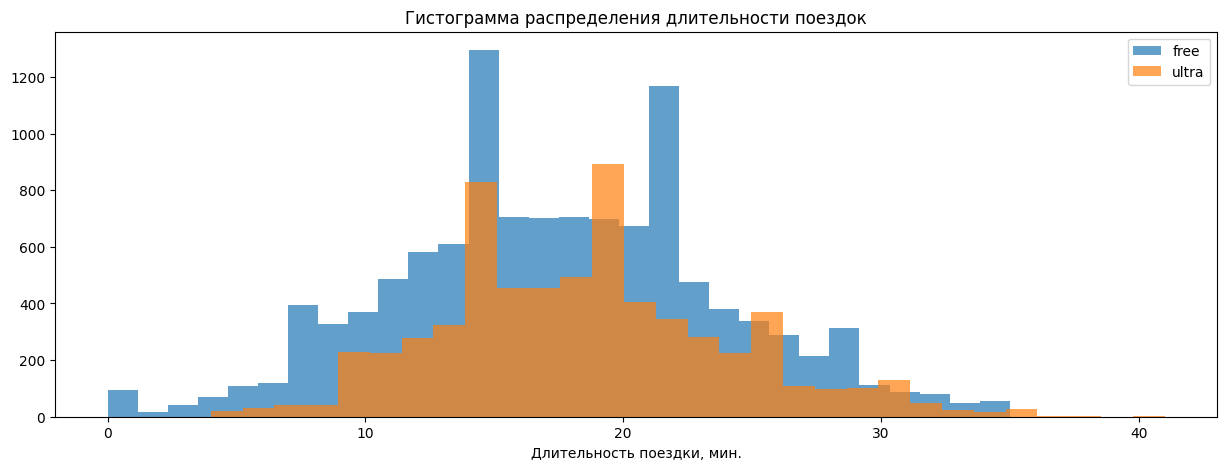

Средняя длительность поездки для пользователей без подписки 17 мин, а для пользователей с подпиской 19 мин


In [22]:
# Гистограмма длительности поездки для пользователей с подпиской и без
plt.figure(figsize=(15, 5))

plt.hist(df_free['duration'], bins=30, alpha=0.7, label='free')

plt.hist(df_ultra['duration'], bins=30, alpha=0.7, label='ultra')

plt.xlabel('Длительность поездки, мин.')
plt.title('Гистограмма распределения длительности поездок')
plt.legend()
plt.show()

# Расчет и вывод на экран средней длительности поездки для пользователей с подпиской и без
mean_duration_free = round(df_free['duration'].mean())
mean_duration_ultra = round(df_ultra['duration'].mean())
print(f'Средняя длительность поездки для пользователей без подписки {mean_duration_free} мин, а для пользователей с подпиской {mean_duration_ultra} мин')

---
## Подсчет выручки

In [23]:
df_gp = df.groupby(['user_id', 'name', 'subscription_type', 'month'], as_index=False)

### Подсчёт агрегированных метрик


In [24]:
df_agg = df_gp.agg(
    total_distance=('distance', 'sum'),  # Сумма расстояний
    total_duration=('duration', 'sum'),  # Сумма продолжительности
    rides_count=('duration', 'count'),   # Количество поездок (по числу элементов в столбце 'duration')
    subscription_type=('subscription_type', 'first'),  # Первое значение типа подписки
    minute_price=('minute_price', 'first'),  # Первое значение для цены за минуту
    start_ride_price=('start_ride_price', 'first'),  # Первое значение для цены старта поездки
    subscription_fee=('subscription_fee', 'first')  # Первое значение для ежемесячной подписки
)


### Функция для подсчёта выручки


In [25]:
def calculate_monthly_revenue(row):
    return (
        row['start_ride_price'] * row['rides_count'] +
        row['minute_price'] * row['total_duration'] +
        row['subscription_fee']
    )

In [26]:
df_agg['monthly_revenue'] = df_agg.apply(calculate_monthly_revenue, axis=1)

### Поиск пользователя с максимальной выручкой

In [27]:
# Группировка по user_id и name, суммирование monthly_revenue
user_revenue = df_agg.groupby(['user_id', 'name'], as_index=False)['monthly_revenue'].sum()

# Нахождение пользователя с максимальной суммарной выручкой
max_user_id = user_revenue.loc[user_revenue['monthly_revenue'].idxmax(), 'user_id']

# Фильтрация данных для этого пользователя и выбор нужных колонок
max_user_data = df_agg[df_agg['user_id'] == max_user_id][['user_id', 'name', 'month', 'rides_count', 'monthly_revenue']]

print(max_user_data)

      user_id       name  month  rides_count  monthly_revenue
8877     1236  Александр      1            2              228
8878     1236  Александр      2            3              614
8879     1236  Александр      3            5              762
8880     1236  Александр      4            1              202
8881     1236  Александр      5            3              574
8882     1236  Александр      6            1              282
8883     1236  Александр      7            1              290
8884     1236  Александр      8            2              452
8885     1236  Александр      9            1              122
8886     1236  Александр     10            3              430
8887     1236  Александр     11            3              494
8888     1236  Александр     12            2              476


---
## Проверка гипотез

In [46]:
%pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 15.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [49]:
import scipy.stats as st

In [51]:
def print_stattest_results(p_value:float, alpha:float = 0.05):
    if p_value < alpha:
        print(f'Полученное значение p_value={p_value} меньше критического уровня alpha={alpha}. Принимаем альтернативную гипотезу.')
    else:
        print(f'Полученное значение p_value={p_value} больше критического уровня alpha={alpha}. Опровергнуть нулевую гипотезу нельзя.')

print_stattest_results(p_value=0.0001)
print_stattest_results(p_value=0.1)

Полученное значение p_value=0.0001 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Полученное значение p_value=0.1 больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.


In [52]:
ultra_duration = df_ultra['duration']
free_duration = df_free['duration']

results = st.ttest_ind(ultra_duration, free_duration, alternative='greater') # Укажите подходящий инструмент здесь
p_value = results.pvalue
print_stattest_results(p_value)
ultra_mean_duration = round(ultra_duration.mean(), 2)
free_mean_duration = round(free_duration.mean(), 2)

print(f'Средняя длительность поездки тарифа Ultra {ultra_mean_duration}')
print(f'Средняя длительность поездки тарифа Free {free_mean_duration}')

Полученное значение p_value=3.1600689435611813e-35 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Средняя длительность поездки тарифа Ultra 18.55
Средняя длительность поездки тарифа Free 17.39


### Длительность поездки: больше или меньше критического значения


Сформулируем нулевую и альтернативную гипотезы:

Нулевая гипотеза (Н0): Средняя дистанция поездки у пользователей с подпиской равна 3130 м.

Альтернативная гипотеза (Н1): Средняя дистанция поездки у пользователей с подпиской больше 3130 м.

In [53]:
null_hypothesis = 3130
ultra_distance = df_ultra['distance']

results = st.ttest_1samp(ultra_distance, null_hypothesis, alternative='greater')
p_value = results.pvalue
print_stattest_results(p_value)

Полученное значение p_value=0.9195368847849785 больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.


### Прибыль от пользователей с подпиской и без

Сформулируем нулевую и альтернативную гипотезы:

Нулевая гипотеза (Н0): Средняя месячная выручка у пользователей с подпиской и без подписки одинаковая.
Альтернативная гипотеза (Н1): Средняя месячная выручка у пользователей с подпиской выше, чем у пользователей без подписки.


In [54]:
revenue_ultra = df_agg[df_agg['subscription_type'] == 'ultra']['monthly_revenue']
revenue_free = df_agg[df_agg['subscription_type'] == 'free']['monthly_revenue']

results = st.ttest_ind(revenue_ultra, revenue_free, alternative='greater')
p_value = results.pvalue
print_stattest_results(p_value)

mean_revenue_ultra = round(revenue_ultra.mean())
mean_revenue_free = round(revenue_free.mean())

print(f'Средняя выручка подписчиков Ultra {mean_revenue_ultra} руб')
print(f'Средняя выручка подписчиков Free {mean_revenue_free} руб')

Полученное значение p_value=1.7274069878387966e-37 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Средняя выручка подписчиков Ultra 359 руб
Средняя выручка подписчиков Free 322 руб


## Распределения

### Расчёт выборочного среднего и стандартного отклонения

In [55]:
# Вычисляем среднее значение
mu = df_ultra.agg({'duration': 'mean'})['duration']

# Вычисляем стандартное отклонение
sigma = df_ultra.agg({'duration': 'std'})['duration']

# Задаём целевое время
target_time = 30

# Делаем вывод
print(f'Средняя длительность поездки {round(mu, 1)}, стандартное отклонение {round(sigma)}.')

Средняя длительность поездки 18.5, стандартное отклонение 6.


### Вычисление значения функции распределения в точке (CDF)

Смоделировать распределение длительности поездок, предполагая, что оно подчиняется нормальному закону, и рассчитать критическую дистанцию, ниже которой находится 90% всех поездок.

In [58]:
# Вычисляем среднее значение
mu = df['distance'].mean()

# Вычисляем стандартное отклонение
sigma = df['distance'].std()

# Вероятность, для которой хотим найти значение (90% случаев)
target_prob = 0.90

# Создаём объект нормального распределения
distance_norm = st.norm(mu, sigma)

# Рассчитываем критическую дистанцию для заданного процентиля поездок
critical_distance = distance_norm.ppf(target_prob)

print(f'{100 * target_prob} % поездок имеют дистанцию ниже критического значения {critical_distance:.2f} М.')

90.0 % поездок имеют дистанцию ниже критического значения 4501.94 М.
